In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
import zipfile

# Define the path to the uploaded zip file and where to extract
zip_file_path = '/content/DATA SET FOR MACHINE LEARNING.zip'
extracted_folder_path = '/content/'

# Extract the zip file contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# After extraction, the path to 'train.csv' (or similar file) will be:
train_file_path = extracted_folder_path + 'train (1).csv'

print(f"Train file extracted and located at: {train_file_path}")


Train file extracted and located at: /content/train (1).csv


In [6]:
# Load the training dataset
data = pd.read_csv('train (1).csv')

# Drop the 'Id' column as it doesn't contribute to the prediction
data = data.drop(['Id'], axis=1)

# Preview the dataset
print(data.head())
print(data.info())  # Check for missing values and data types


   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     20850

In [7]:
# Check the number of missing values in each column
missing_data = data.isnull().sum().sort_values(ascending=False)
print(missing_data[missing_data > 0])

# Handle missing values
# Fill numerical columns with the median
for col in data.select_dtypes(include=['float64', 'int64']):
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical columns with the most frequent category
for col in data.select_dtypes(include=['object']):
    data[col].fillna(data[col].mode()[0], inplace=True)

# Verify that there are no more missing values
print(data.isnull().sum().max())  # Should print 0


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64
0


In [8]:
# Label encode ordinal features and one-hot encode nominal features
label_enc = LabelEncoder()

# Apply Label Encoding to ordinal features if needed
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual']
for col in ordinal_cols:
    if col in data.columns:
        data[col] = label_enc.fit_transform(data[col])

# Apply One-Hot Encoding to nominal features
data = pd.get_dummies(data, drop_first=True)

# Preview the dataset after encoding
print(data.head())


   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond  ...  SaleType_ConLI  \
0          2003       196.0          2          4  ...           False   
1          1976         0.0          3          4  ...           False   
2          2002       162.0          2          4  ...           False   
3          1970         0.0          3          4  ...           False   
4          2000       350.0          2          4  ...           False   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0           False         False     

In [9]:
# Separate features and target variable
X = data.drop('SalePrice', axis=1)  # Features
y = data['SalePrice']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply standard scaling to numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# Train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lin_reg.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr}, RMSE: {rmse_lr}, R²: {r2_lr}")


Linear Regression MAE: 1793209070.8240068, RMSE: 30537190380.042843, R²: -121575011428.52777


In [11]:
# Train the Random Forest model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")


Random Forest MAE: 17583.104212328766, RMSE: 28585.648818358502, R²: 0.8934674619704103


In [12]:
# Train the XGBoost model
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb}, RMSE: {rmse_xgb}, R²: {r2_xgb}")


XGBoost MAE: 17802.90615635702, RMSE: 28053.41706843829, R²: 0.8973975777626038


In [13]:
# Train the LightGBM model
lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

# Predict on test data
y_pred_lgb = lgb_reg.predict(X_test)

# Evaluate the model
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM MAE: {mae_lgb}, RMSE: {rmse_lgb}, R²: {r2_lgb}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3257
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 144
[LightGBM] [Info] Start training from score 181441.541952
LightGBM MAE: 17178.814401541807, RMSE: 29625.28357238092, R²: 0.8855775617572021


In [14]:
# Summarize model performance
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_lgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    'R²': [r2_lr, r2_rf, r2_xgb, r2_lgb]
})

print(models)


               Model           MAE          RMSE            R²
0  Linear Regression  1.793209e+09  3.053719e+10 -1.215750e+11
1      Random Forest  1.758310e+04  2.858565e+04  8.934675e-01
2            XGBoost  1.780291e+04  2.805342e+04  8.973976e-01
3           LightGBM  1.717881e+04  2.962528e+04  8.855776e-01


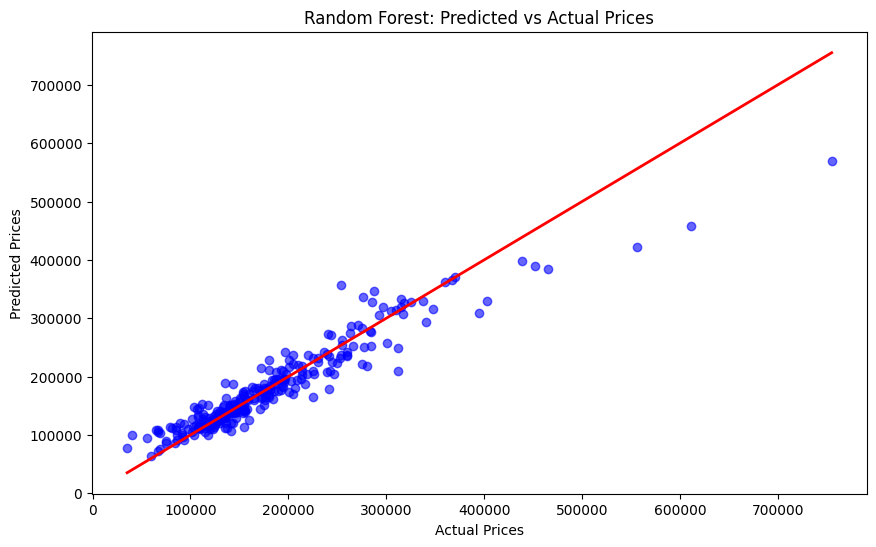

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot to compare predicted vs actual house prices
def plot_pred_vs_actual(y_test, y_pred, model_name):
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='b')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.title(f'{model_name}: Predicted vs Actual Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.show()

# Example for Random Forest
plot_pred_vs_actual(y_test, y_pred_rf, "Random Forest")


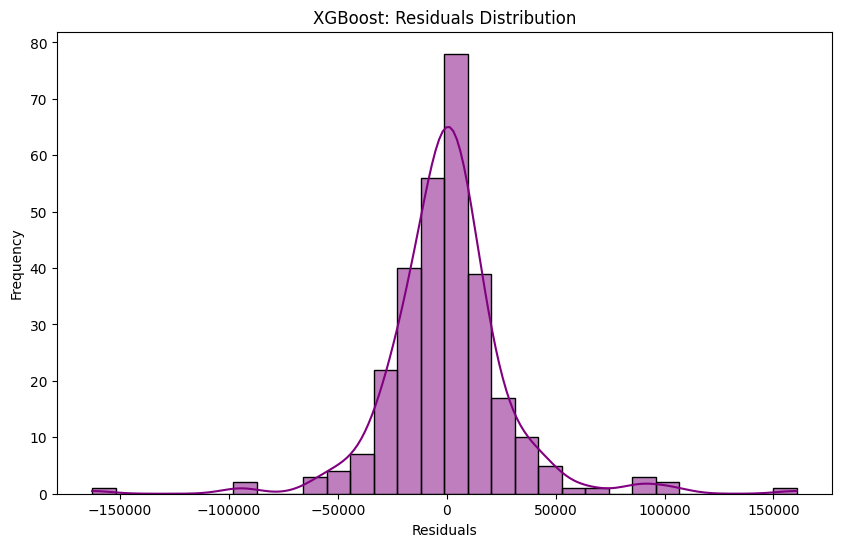

In [17]:
# Residual plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10,6))
    sns.histplot(residuals, kde=True, color='purple', bins=30)
    plt.title(f'{model_name}: Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

# Example for XGBoost
plot_residuals(y_test, y_pred_xgb, "XGBoost")


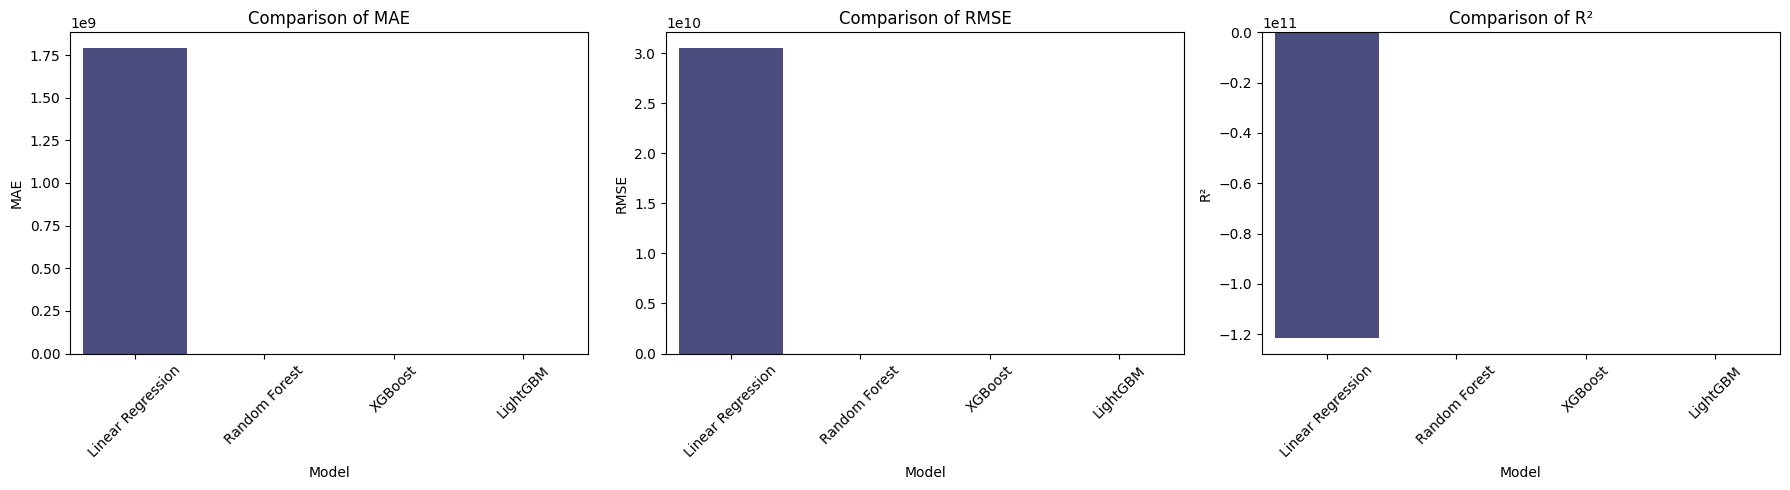

In [18]:
# Bar plot to compare model performance metrics
def compare_model_performance(models_df):
    metrics = ['MAE', 'RMSE', 'R²']

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics):
        sns.barplot(x='Model', y=metric, data=models_df, ax=ax[i], palette='viridis')
        ax[i].set_title(f'Comparison of {metric}')
        ax[i].set_xlabel('Model')
        ax[i].set_ylabel(metric)
        ax[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# Assuming you have a DataFrame named models with model performance
compare_model_performance(models)


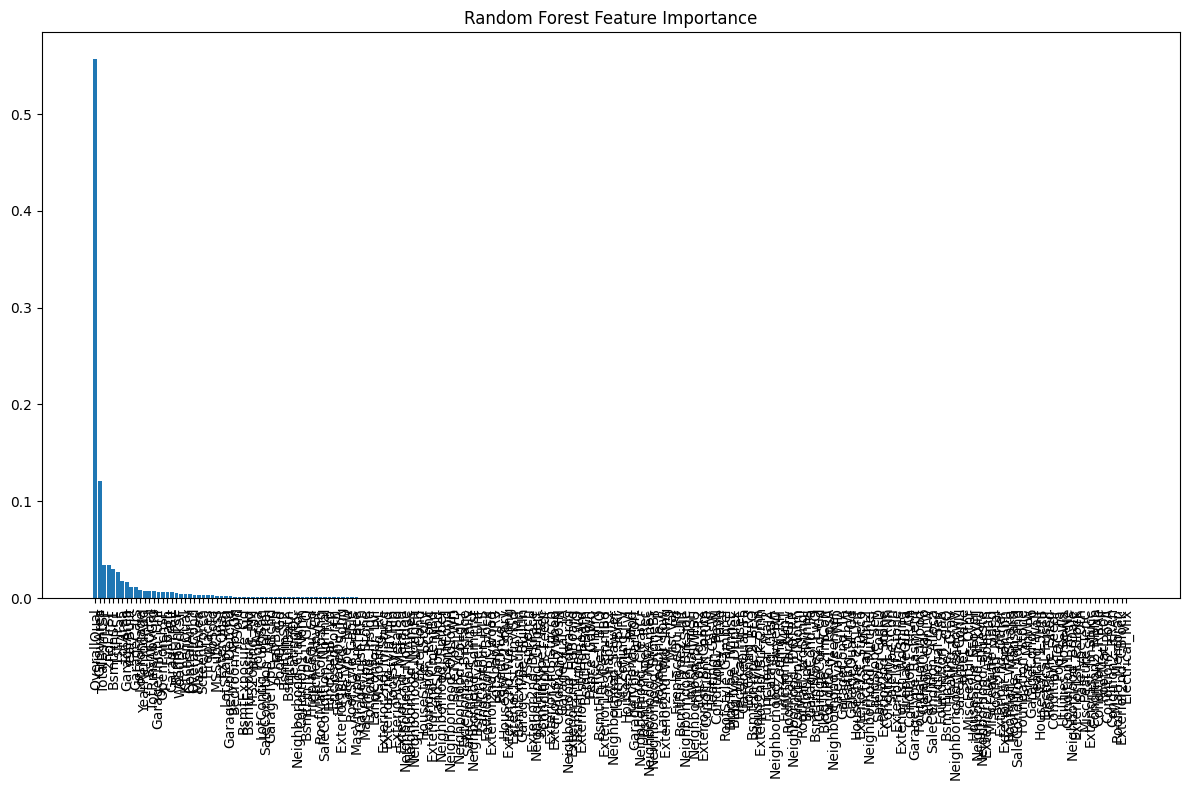

In [19]:
# Feature importance plot (for Random Forest or XGBoost)
def plot_feature_importance(model, X, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12,8))
    plt.title(f'{model_name} Feature Importance')
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Example for Random Forest
plot_feature_importance(rf_reg, X, "Random Forest")


In [20]:
# Import the PCA module
from sklearn.decomposition import PCA

# Split the dataset into features (X) and target (y)
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

# Handle categorical variables (one-hot encoding for simplicity)
X = pd.get_dummies(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA (reduce to 95% variance explained)
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Dictionary to store model results
model_results = {}

# Function to evaluate and store results
def evaluate_model(model, model_name):
    # Fit the model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

    # Print results
    print(f'{model_name} Performance:')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R²: {r2}\n')

# 1. Linear Regression
lr_model = LinearRegression()
evaluate_model(lr_model, 'Linear Regression')

# 2. Random Forest
rf_model = RandomForestRegressor(random_state=42)
evaluate_model(rf_model, 'Random Forest')

# 3. XGBoost
xgb_model = XGBRegressor(random_state=42)
evaluate_model(xgb_model, 'XGBoost')

# 4. LightGBM
lgbm_model = LGBMRegressor(random_state=42)
evaluate_model(lgbm_model, 'LightGBM')

# Summary of all model performances
model_df = pd.DataFrame(model_results).T
print(model_df)

# Optional: Print PCA explained variance ratio
print(f'Explained variance by each component: {pca.explained_variance_ratio_}')


Linear Regression Performance:
RMSE: 33190.308212431744
MAE: 21433.492763012455
R²: 0.8563820456287747

Random Forest Performance:
RMSE: 36330.38918507588
MAE: 20793.415308219177
R²: 0.8279216368787119

XGBoost Performance:
RMSE: 43135.005771261705
MAE: 20981.717653039384
R²: 0.75742506980896

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38505
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 151
[LightGBM] [Info] Start training from score 181441.541952
LightGBM Performance:
RMSE: 37511.56023831997
MAE: 20341.76478661362
R²: 0.816550546416835

                           RMSE           MAE        R²
Linear Regression  33190.308212  21433.492763  0.856382
Random Forest      36330.389185  20793.415308  0.827922
XGBoost            43135.005771  